# Introduction to Speech Processing Final Project: Voiced / Unvoiced / Background

This notebook develops three **signal-processing** algorithms for frame-level speech labeling:
- `-1` = **Background / silence**
- `0` = **Unvoiced** (fricatives, plosives, noise-like)
- `1` = **Voiced** (periodic, vowels/sonorants)

Audio is mono at **16 kHz**, framed at **16 ms** with **8 ms** hop. Each algorithm uses handcrafted rules (no learned model) to assign V/UV/B labels; a downstream SVM is used only for **speaker recognition** as an indirect quality check.

### Algorithm lineup
1) **HHTC – Hybrid Hierarchical Time-Domain**
   - Short-time energy, RMS, ZCR, autocorrelation peak
   - Adaptive thresholds to separate silence → speech → voiced vs unvoiced

2) **SSC – Spectral Shape Classifier**
   - Spectral centroid, flatness, rolloff (85%), plus ZCR
   - Percentile-based thresholds on spectral shape to distinguish voiced vs unvoiced

3) **HDGC – Hierarchical Dual-Geometry Classifier** (paper-aligned)
   - Log-magnitude STFT, dyadic partition tree over frequency bins
   - Tree-based EMD-like distances between frames
   - Two-step split: (a) silence vs speech by energy, (b) voiced vs unvoiced by high/low band ratio

### What we evaluate
Because no frame-level ground truth exists, we **proxy** V/UV/B quality via a speaker-recognition task:
- Extract 53-D file-level features per algorithm (13 sequence stats from its labels + 40 MFCC stats on voiced frames).
- Train an **SVM (RBF)** from scratch for speaker ID.
- Higher speaker accuracy ⇒ cleaner V/UV/B segmentation for that algorithm on this dataset.

We also include qualitative plots (waveform + colored labels) to visually inspect segmentation behavior.

## Table of Contents
- [Setup and Data](#setup-and-data)
- [Frame-Based Signal Utilities](#frame-based-signal-utilities)
- [Spectral Features](#spectral-features)
- [Label Post-Processing](#label-post-processing)
- [Algorithm: HHTC](#algorithm-hhtc)
- [Algorithm: SSC](#algorithm-ssc)
- [Algorithm: HDGC](#algorithm-hdgc)
- [Visualization](#visualization)
  - [Example: Visual Comparison](#example-visual-comparison)
- [Sequence-Level Features](#sequence-level-features)
- [File-Level Features for Speaker ID](#file-level-features-for-speaker-id)
- [Training & Comparison via Speaker Recognition](#training--comparison-via-speaker-recognition)
- [Inspecting a Test Example](#inspecting-a-test-example)

In [6]:
# !pip install librosa soundfile scikit-learn matplotlib

import os
import glob
import numpy as np
import librosa
import matplotlib.pyplot as plt

from scipy.signal import medfilt
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Setup and Data

Local paths (next to this notebook):
- Input train data: `./data/<speaker>/*.wav`
- Input test data: `./test/<speaker>/*.wav`
- Outputs (written by exporters): `./output/<algorithm>/<speaker>/<file>_labels.tsv`

Dataset specifics:
- 3 speakers: LeNguyenTuanAnh, LuongBinhMinh, TranQuangThai
- 4 words, each recorded 10 times (indices 0–9) per speaker per split:
  - yes → /jes/
  - yeah → /jeə/
  - present → /ˈpreznt/
  - here → /hɪə/
- Train split: 120 samples total
- Test split: 120 samples total
- Audio: 16 kHz, mono (single channel)

In this cell we:
- Import required libraries for signal processing, machine learning, and plotting.
- Define global constants:
  - Sampling rate: `SR = 16000` Hz
  - Frame length and hop: `FRAME_MS = 16`, `HOP_MS = 8` (and sample counts)
- Define frame-level labels:
  - `LABEL_BACKGROUND = -1`
  - `LABEL_UNVOICED = 0`
  - `LABEL_VOICED = 1`
- Set dataset paths (`DATA_ROOT`, `TEST_ROOT`, `TRAIN_ROOT` alias) and a file collector for `(audio_path, speaker_name)` pairs.

In [7]:
SR = 16000          # sampling rate
FRAME_MS = 16       # frame length in ms
HOP_MS = 8          # hop length in ms

FRAME_LEN = int(SR * FRAME_MS / 1000)
HOP_LEN   = int(SR * HOP_MS  / 1000)

LABEL_BACKGROUND = -1
LABEL_UNVOICED   = 0
LABEL_VOICED     = 1

PROJECT_ROOT = os.path.abspath(os.getcwd())
DATA_ROOT = os.path.join(PROJECT_ROOT, "data")
TEST_ROOT  = os.path.join(PROJECT_ROOT, "test")
OUTPUT_ROOT = os.path.join(PROJECT_ROOT, "output")  # algorithm outputs saved here

# backward compatibility with earlier variable name
TRAIN_ROOT = DATA_ROOT

In [8]:
# Ensure expected folders exist locally
for path in (DATA_ROOT, TEST_ROOT):
    if not os.path.isdir(path):
        raise FileNotFoundError(f"Expected folder not found: {path}")

os.makedirs(OUTPUT_ROOT, exist_ok=True)
print("Project root:", PROJECT_ROOT)
print("Data root:", DATA_ROOT)
print("Test root:", TEST_ROOT)
print("Output root:", OUTPUT_ROOT)

Project root: d:\ImportantProjects\SpeechProcessing\Project
Data root: d:\ImportantProjects\SpeechProcessing\Project\data
Test root: d:\ImportantProjects\SpeechProcessing\Project\test
Output root: d:\ImportantProjects\SpeechProcessing\Project\output


## Frame-Based Signal Utilities

Low-level helpers used by all three algorithms:
- `frame_signal` – slice waveform into overlapping frames and time stamps.
- `rms_energy`, `ste_energy` – loudness measures per frame.
- `zcr_rate` – zero-crossing rate (noise/aperiodicity cue).
- `acf_peak` – max normalized autocorrelation peak (periodicity cue).

In [9]:
# --- basic framing helper ---
def frame_signal(y, frame_len, hop_len):
    """Vectorized framing with center timestamps; pad if shorter than a frame."""
    y = np.asarray(y, dtype=np.float32)
    if len(y) < frame_len:
        y = np.pad(y, (0, frame_len - len(y)))
    n_frames = 1 + int((len(y) - frame_len) / hop_len)
    idx = np.tile(np.arange(0, frame_len), (n_frames, 1)) + \
          np.tile(np.arange(0, n_frames * hop_len, hop_len), (frame_len, 1)).T
    frames = y[idx]
    times = (idx[:, 0] + frame_len // 2) / SR
    return frames, times

def rms_energy(frames):
    return np.sqrt(np.mean(frames**2, axis=1) + 1e-12)

def ste_energy(frames):
    return np.sum(frames**2, axis=1)

def zcr_rate(frames):
    signs = np.sign(frames)
    signs[signs == 0] = 1
    return np.mean(signs[:, :-1] * signs[:, 1:] < 0, axis=1)


In [10]:
def collect_files(root_dir):
    """Return list of (filepath, speaker_name)."""
    file_list = []
    speakers = sorted(d for d in os.listdir(root_dir)
                      if os.path.isdir(os.path.join(root_dir, d)))
    for spk in speakers:
        spk_dir = os.path.join(root_dir, spk)
        wavs = glob.glob(os.path.join(spk_dir, "*.wav"))
        for w in sorted(wavs):
            file_list.append((w, spk))
    return file_list

train_files = collect_files(TRAIN_ROOT)
test_files  = collect_files(TEST_ROOT)

print("Train files:", len(train_files))
print("Test files:", len(test_files))
print("Speakers:", sorted({s for _, s in train_files + test_files}))


Train files: 120
Test files: 120
Speakers: ['LeNguyenTuanAnh', 'LuongBinhMinh', 'TranQuangThai']


In [11]:
def ste_energy(frames):
    return np.sum(frames**2, axis=1)

def zcr_rate(frames):
    signs = np.sign(frames)
    signs[signs == 0] = 1
    return np.mean(signs[:, :-1] * signs[:, 1:] < 0, axis=1)

def acf_peak(frames, max_lag=80):
    """Normalized ACF peak (excluding lag 0) per frame."""
    n_frames, L = frames.shape
    peaks = np.zeros(n_frames)
    for i in range(n_frames):
        x = frames[i] - np.mean(frames[i])
        if np.allclose(x, 0):
            peaks[i] = 0.0
            continue
        r = np.correlate(x, x, mode="full")[L-1 : L-1+max_lag]
        if np.max(np.abs(r)) < 1e-8:
            peaks[i] = 0.0
        else:
            r = r / np.max(np.abs(r))
            peaks[i] = np.max(r[1:])   # skip lag 0
    return peaks



## Spectral Features

Frequency-domain helpers:
- `spectral_features` – STFT magnitude → spectral centroid & flatness per frame.
- `tf_periodicity` – simple periodicity measure from log-STFT (max-minus-mean per frame).

In [12]:
def spectral_features(y):
    # STFT magnitude for the current waveform (matches frame/hop of classifiers)
    S = np.abs(librosa.stft(y, n_fft=512, hop_length=HOP_LEN, win_length=FRAME_LEN))
    # Brightness and tonal-vs-noise descriptors per frame
    sc = librosa.feature.spectral_centroid(S=S, sr=SR)[0]
    sf = librosa.feature.spectral_flatness(S=S)[0]
    # Align lengths with other frame-wise quantities
    n_frames = min(len(sc), len(sf))
    return sc[:n_frames], sf[:n_frames]

In [13]:
def tf_periodicity(y):
    """Rough periodicity: how peaky each log-spectrum frame is (max - mean)."""
    S = np.abs(librosa.stft(y, n_fft=512, hop_length=HOP_LEN, win_length=FRAME_LEN))
    S_log = np.log10(S + 1e-8)
    max_per_frame = np.max(S_log, axis=0)
    mean_per_frame = np.mean(S_log, axis=0)
    periodicity = (max_per_frame - mean_per_frame)
    return periodicity

## Label Post-Processing

Raw labels can flicker. Utilities:
- `smooth_labels` – short-window majority/median filter.
- `remove_short_segments` – merge runs shorter than `min_run`.
- `postprocess_labels` – combine smoothing + short-run removal for cleaner sequences.

In [14]:
LABEL_BACKGROUND = -1
LABEL_UNVOICED   = 0
LABEL_VOICED     = 1

def smooth_labels(labels, win=5):
    """Median/majority smoothing over a small temporal window."""
    if win <= 1:
        return labels
    labels = np.asarray(labels, dtype=int)
    pad = win // 2
    ext = np.pad(labels, pad_width=pad, mode="edge")
    smoothed = np.empty_like(labels)
    for i in range(len(labels)):
        window = ext[i:i+win]
        # shift by +1 so values become {0,1,2} for bincount
        counts = np.bincount(window + 1, minlength=3)
        smoothed[i] = np.argmax(counts) - 1
    return smoothed


In [15]:
def remove_short_segments(labels, min_run=3):
    """Remove very short label runs (spikes) by merging them into neighbors.

    Any contiguous run of identical labels shorter than `min_run`
    is replaced by the label of its left/right neighbor (preferring
    the majority when both exist).
    """
    labels = np.asarray(labels, dtype=int)
    n = len(labels)
    if n == 0 or min_run <= 1:
        return labels

    out = labels.copy()
    start = 0
    while start < n:
        end = start + 1
        while end < n and labels[end] == labels[start]:
            end += 1
        run_len = end - start
        if run_len < min_run:
            left = labels[start - 1] if start > 0 else None
            right = labels[end] if end < n else None

            if left is not None and right is not None:
                # if both sides exist, pick the majority / later label
                out[start:end] = left if left == right else right
            elif left is not None:
                out[start:end] = left
            elif right is not None:
                out[start:end] = right
        start = end
    return out


def postprocess_labels(raw_labels, smooth_win=7, min_run=3):
    """Apply smoothing + short-run removal to reduce flickering labels."""
    labels = smooth_labels(raw_labels, win=smooth_win)
    labels = remove_short_segments(labels, min_run=min_run)
    return labels


## Algorithm: HHTC (Hybrid Hierarchical Time-Domain)

Time-domain rules using STE/RMS, ZCR, and autocorrelation peak:
1) Silence gating via RMS threshold.
2) Speech frames: high ZCR or low ACF → unvoiced; else voiced.
3) Apply `postprocess_labels` for temporal smoothing.
Outputs labels in `{-1, 0, 1}` plus time axis for plotting.

In [16]:
def hhtc_classify(y, postprocess=True):
    """Time-domain heuristic using RMS gate, ZCR/ACF split, and optional smoothing."""
    frames, times = frame_signal(y, FRAME_LEN, HOP_LEN)

    E_ste = ste_energy(frames)
    E_rms = rms_energy(frames)
    Z = zcr_rate(frames)
    R = acf_peak(frames)

    max_rms = np.max(E_rms) if len(E_rms) else 0.0
    theta_sil = 0.1 * max_rms if max_rms > 0 else 0.0
    # derive thresholds on speech-only frames to avoid silence bias
    speech_idx = E_rms > theta_sil
    if np.any(speech_idx):
        theta_zcr = np.median(Z[speech_idx])
        theta_acf = np.median(R[speech_idx])
    else:
        theta_zcr = np.median(Z)
        theta_acf = np.median(R)

    labels = np.empty(len(E_rms), dtype=int)

    for k in range(len(E_rms)):
        if E_rms[k] < theta_sil:
            labels[k] = LABEL_BACKGROUND
        else:
            if (Z[k] > theta_zcr) or (R[k] < theta_acf):
                labels[k] = LABEL_UNVOICED
            else:
                labels[k] = LABEL_VOICED

    if postprocess:
        labels = postprocess_labels(labels, smooth_win=7, min_run=3)

    return labels, times


## Algorithm: SSC (Spectral Shape Classifier)

Spectral-shape rules using centroid, flatness, rolloff, and ZCR:
- Silence via RMS threshold.
- Bright + flat spectra → unvoiced; tonal + moderate centroid → voiced; ZCR as tie-breaker.
- Thresholds are percentile-based on speech frames. Post-processed for stability.

In [17]:
def ssc_classify(y, postprocess=True):
    """Spectral-shape rules with percentile thresholds on centroid/flatness/rolloff/ZCR."""
    frames, times_f = frame_signal(y, FRAME_LEN, HOP_LEN)
    rms = rms_energy(frames)
    zcr = zcr_rate(frames)

    S = np.abs(librosa.stft(
        y, n_fft=512, hop_length=HOP_LEN,
        win_length=FRAME_LEN, window="hann",
    ))
    sc = librosa.feature.spectral_centroid(S=S, sr=SR)[0]
    sf = librosa.feature.spectral_flatness(S=S)[0]
    sr85 = librosa.feature.spectral_rolloff(S=S, sr=SR, roll_percent=0.85)[0]

    n = min(len(rms), len(zcr), len(sc), len(sf), len(sr85))
    rms, zcr = rms[:n], zcr[:n]
    sc, sf, sr85 = sc[:n], sf[:n], sr85[:n]
    times = times_f[:n]

    max_rms = np.max(rms) if n > 0 else 0.0
    theta_sil = 0.1 * max_rms if max_rms > 0 else 0.0
    # use speech-only frames to set spectral thresholds
    speech_idx = rms > theta_sil
    if np.any(speech_idx):
        sc_s, sf_s, sr85_s, zcr_s = sc[speech_idx], sf[speech_idx], sr85[speech_idx], zcr[speech_idx]
    else:
        sc_s, sf_s, sr85_s, zcr_s = sc, sf, sr85, zcr

    theta_flat_hi = np.percentile(sf_s, 60)
    theta_flat_lo = np.percentile(sf_s, 40)
    theta_cent_mid = np.percentile(sc_s, 50)
    theta_roll_hi = np.percentile(sr85_s, 60)
    theta_zcr_hi = np.percentile(zcr_s, 60)

    labels = np.empty(n, dtype=int)
    for k in range(n):
        if rms[k] < theta_sil:
            labels[k] = LABEL_BACKGROUND
        else:
            if ((sf[k] > theta_flat_hi and sc[k] > theta_cent_mid) or
                (sr85[k] > theta_roll_hi and zcr[k] > theta_zcr_hi)):
                labels[k] = LABEL_UNVOICED
            elif (sf[k] < theta_flat_lo and sc[k] <= theta_cent_mid):
                labels[k] = LABEL_VOICED
            else:
                labels[k] = LABEL_VOICED if zcr[k] < theta_zcr_hi else LABEL_UNVOICED

    if postprocess:
        labels = postprocess_labels(labels, smooth_win=7, min_run=3)

    return labels, times


## Algorithm: HDGC (Hierarchical Dual-Geometry Classifier)

Paper-aligned two-step dual-geometry workflow on log-STFT:
- Build `X = log1p(|STFT|)` (e.g., `n_fft=1024`).
- Construct a dyadic partition tree over frequency bins (`build_freq_partition_tree`).
- EMD-like distance between frames via tree averages (`emd_distance_over_tree`).
- Step 1 (silence vs speech): bipartition from the distance matrix (`bipartition_from_distance`); lower-energy cluster → silence.
- Step 2 (voiced vs unvoiced on speech-only): bipartition again; label by high/low energy ratio (~1.5 kHz split).
- Post-process labels for temporal consistency.
Helper utilities support the tree/distance steps.

In [18]:
def hdgc_features(y):
    """Compute HDGC feature bundle (time + time–frequency geometry)."""

    # time-domain
    frames, times_f = frame_signal(y, FRAME_LEN, HOP_LEN)
    rms = rms_energy(frames)
    zcr = zcr_rate(frames)

    # frequency-domain STFT
    n_fft = 512
    S = np.abs(librosa.stft(
        y,
        n_fft=n_fft,
        hop_length=HOP_LEN,
        win_length=FRAME_LEN,
        window="hann",
    ))
    S_log = np.log10(S + 1e-8)

    sc = librosa.feature.spectral_centroid(S=S, sr=SR)[0]
    sf = librosa.feature.spectral_flatness(S=S)[0]
    roll = librosa.feature.spectral_rolloff(S=S, sr=SR, roll_percent=0.85)[0]

    # band-limited energies (e.g. <2kHz vs >4kHz)
    freqs = librosa.fft_frequencies(sr=SR, n_fft=n_fft)
    low_mask = freqs <= 2000.0
    high_mask = freqs >= 4000.0
    low_energy = np.sum((S[low_mask, :])**2, axis=0)
    high_energy = np.sum((S[high_mask, :])**2, axis=0)
    band_ratio = high_energy / (low_energy + high_energy + 1e-8)  # high / total

    # HPSS for harmonic ratio
    H, P = librosa.decompose.hpss(S)
    harm_energy = np.sum(H**2, axis=0)
    perc_energy = np.sum(P**2, axis=0)
    harm_ratio = harm_energy / (harm_energy + perc_energy + 1e-8)

    # align all features to same frame count
    n = min(
        len(rms),
        S.shape[1],
        len(sc),
        len(sf),
        len(roll),
        len(band_ratio),
        len(harm_ratio),
        len(zcr),
    )
    feats = {
        "rms": rms[:n],
        "zcr": zcr[:n],
        "centroid": sc[:n],
        "flatness": sf[:n],
        "rolloff": roll[:n],
        "band_ratio": band_ratio[:n],
        "harm_ratio": harm_ratio[:n],
        "times": times_f[:n],
        "S_log": S_log[:, :n],
    }
    return feats


In [19]:
# Helper utilities for the dual-geometry HDGC algorithm
# - build_freq_partition_tree: multiscale partition over frequency bins
# - emd_distance_over_tree: EMD-like distance using tree-averaged means
# - bipartition_from_distance: split columns into two folders from a distance matrix

def build_freq_partition_tree(n, min_size=1):
    """Create a dyadic partition tree over n indices (fine-to-coarse)."""
    if n <= 0:
        return []
    folders = []
    current = [np.arange(n)]
    while current:
        folders.extend(current)
        new_level = []
        for arr in current:
            if len(arr) > min_size:
                mid = len(arr) // 2
                if mid > 0:
                    new_level.append(arr[:mid])
                    new_level.append(arr[mid:])
        current = new_level
    return folders


def emd_distance_over_tree(X, folders, beta=0.5):
    """Compute an EMD-like distance between columns of X using a tree of row folders."""
    if X.size == 0 or len(folders) == 0:
        return np.zeros((X.shape[1], X.shape[1]))

    n_cols = X.shape[1]
    means = np.empty((len(folders), n_cols), dtype=float)
    weights = np.empty(len(folders), dtype=float)
    n_rows = float(X.shape[0])

    for idx, folder in enumerate(folders):
        means[idx] = X[folder, :].mean(axis=0)
        weights[idx] = (len(folder) / n_rows) ** beta

    diffs = np.abs(means[:, :, None] - means[:, None, :])
    D = np.tensordot(weights, diffs, axes=(0, 0))
    D = 0.5 * (D + D.T)
    np.fill_diagonal(D, 0.0)
    return D


def bipartition_from_distance(distance_matrix):
    """Split columns into two clusters using hierarchical clustering on a distance matrix."""
    n = distance_matrix.shape[0]
    if n == 0:
        return np.array([], dtype=int)
    if n == 1:
        return np.array([0], dtype=int)
    if np.allclose(distance_matrix, 0):
        labels = np.zeros(n, dtype=int)
        labels[n // 2 :] = 1
        return labels

    condensed = squareform(distance_matrix, checks=False)
    Z = linkage(condensed, method="average")
    clusters = fcluster(Z, t=2, criterion="maxclust") - 1  # -> {0,1}
    return clusters

In [20]:
def hdgc_classify(
    y,
    postprocess=True,
    n_fft=1024,
    hop_length=HOP_LEN,
    freq_split_hz=1500.0,
    beta=0.5,
):
    """
    Two-step dual-geometry clustering on log-STFT:
      1) Tree-based EMD distance over frames → split silence vs speech (energy picks silence).
      2) Re-run on speech frames → split voiced vs unvoiced; choose voiced by low high/low ratio.
    """

    S = np.abs(
        librosa.stft(
            y,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=FRAME_LEN,
            window="hann",
        )
    )
    X = np.log1p(S)
    n_frames = X.shape[1]
    times = librosa.frames_to_time(np.arange(n_frames), sr=SR, hop_length=hop_length, n_fft=n_fft)

    if n_frames == 0:
        return np.array([], dtype=int), np.array([], dtype=float)

    freq_folders = build_freq_partition_tree(X.shape[0], min_size=1)
    D_cols = emd_distance_over_tree(X, freq_folders, beta=beta)
    clusters_step1 = bipartition_from_distance(D_cols)

    S_pow = S ** 2
    energy_clusters = []
    for c in (0, 1):
        idx = clusters_step1 == c
        if not np.any(idx):
            energy_clusters.append(np.inf)
        else:
            energy_clusters.append(np.mean(S_pow[:, idx]))
    silence_cluster = int(np.argmin(energy_clusters))

    labels = np.full(n_frames, LABEL_BACKGROUND, dtype=int)
    speech_mask = clusters_step1 != silence_cluster

    if np.any(speech_mask):
        speech_indices = np.where(speech_mask)[0]

        if speech_mask.sum() == 1:
            labels[speech_indices] = LABEL_VOICED
        else:
            X_speech = X[:, speech_mask]
            S_speech = S_pow[:, speech_mask]

            D_cols_speech = emd_distance_over_tree(X_speech, freq_folders, beta=beta)
            clusters_step2 = bipartition_from_distance(D_cols_speech)

            freqs = librosa.fft_frequencies(sr=SR, n_fft=n_fft)
            low_mask = freqs < freq_split_hz
            high_mask = freqs >= freq_split_hz

            ratios = []
            for c in (0, 1):
                idx = clusters_step2 == c
                if not np.any(idx):
                    ratios.append(np.inf)
                else:
                    high_energy = np.sum(S_speech[high_mask][:, idx])
                    low_energy = np.sum(S_speech[low_mask][:, idx]) + 1e-8
                    ratios.append(high_energy / low_energy)

            voiced_cluster = int(np.argmin(ratios))
            unvoiced_cluster = 1 - voiced_cluster

            labels[speech_indices[clusters_step2 == voiced_cluster]] = LABEL_VOICED
            labels[speech_indices[clusters_step2 == unvoiced_cluster]] = LABEL_UNVOICED

    if postprocess and len(labels):
        labels = postprocess_labels(labels, smooth_win=7, min_run=3)

    return labels, times

## Exporting algorithm outputs locally
Run the three classifiers on each file and save their frame-level labels (time in seconds + label) into the `output/` folder, organized by algorithm and speaker.

In [21]:
ALGORITHMS = [
    ("HHTC", hhtc_classify),
    ("SSC", ssc_classify),
    ("HDGC", hdgc_classify),
]

def export_algorithm_outputs(file_list, output_root=OUTPUT_ROOT):
    """Save frame-level labels for each algorithm to output/<algo>/<speaker>/<file>_labels.tsv."""
    for path, spk in file_list:
        y, _ = librosa.load(path, sr=SR)
        for algo_name, algo_func in ALGORITHMS:
            labels, times = algo_func(y)
            speaker_dir = os.path.join(output_root, algo_name, spk)
            os.makedirs(speaker_dir, exist_ok=True)
            base = os.path.splitext(os.path.basename(path))[0]
            out_path = os.path.join(speaker_dir, f"{base}_labels.tsv")
            data = np.column_stack([times, labels])
            np.savetxt(
                out_path,
                data,
                fmt="%.6f\t%d",
                header="time_s\tlabel (-1=bg,0=uv,1=v)",
                comments="",
            )

print("Exporting labels for all train and test files...", flush=True)
export_algorithm_outputs(train_files + test_files, output_root=OUTPUT_ROOT)
print(f"Finished writing labels under: {OUTPUT_ROOT}")

Exporting labels for all train and test files...
Finished writing labels under: d:\ImportantProjects\SpeechProcessing\Project\output


## Visualization

Helpers to plot waveform with color-coded V/UV/B labels for qualitative inspection.

In [22]:
COLOR_MAP = {
    LABEL_BACKGROUND: "#4169E1",  # blue
    LABEL_UNVOICED:   "#FFA500",  # orange
    LABEL_VOICED:     "#2E8B57",  # green
}

def plot_classification(y, sr, labels, times, title=""):
    t_audio = np.arange(len(y)) / sr

    fig, ax = plt.subplots(figsize=(14, 3))
    ax.plot(t_audio, y, linewidth=0.8, alpha=0.9, color="black")

    # colored background per frame
    frame_dur = HOP_LEN / sr
    for lab, t in zip(labels, times):
        t0 = t - frame_dur/2
        t1 = t + frame_dur/2
        ax.axvspan(t0, t1, color=COLOR_MAP[lab], alpha=0.35, linewidth=0)

    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    handles = [
        plt.Line2D([0],[0], color=COLOR_MAP[LABEL_BACKGROUND], lw=8, label="Background (Silence)"),
        plt.Line2D([0],[0], color=COLOR_MAP[LABEL_UNVOICED],   lw=8, label="Unvoiced (Noise/Fricative)"),
        plt.Line2D([0],[0], color=COLOR_MAP[LABEL_VOICED],     lw=8, label="Voiced (Periodic/Vowel)"),
    ]
    ax.legend(handles=handles, loc="upper right")
    plt.tight_layout()
    plt.show()

    # print sequence
    seq_str = "{ " + " ".join(str(int(x)) for x in labels) + " }"
    uniq, counts = np.unique(labels, return_counts=True)
    print("Sequence:", seq_str)
    print("Counts:", dict(zip(uniq, counts)))


### Example: Visual Comparison
Run HHTC, SSC, and HDGC on the same file; plot waveform and predicted labels to compare segmentation behavior.


=== HHTC on yes_4_LeNguyenTuanAnh.wav (LeNguyenTuanAnh) ===


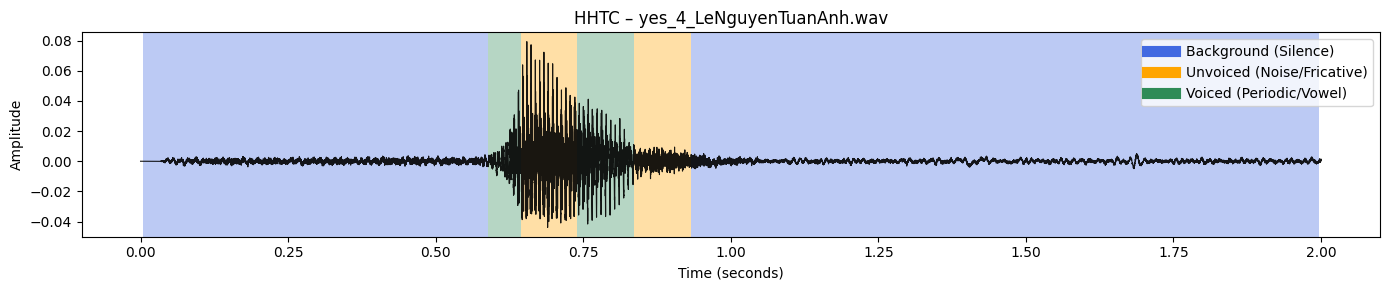

Sequence: { -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 }
Counts: {np.int64(-1): np.int64(206), np.int64(0): np.int64(24), np.int64(1): np.int64(19)}

=== SSC on yes_4_LeNguyenTuanAnh.wav (LeNguyenTuanAnh) ===


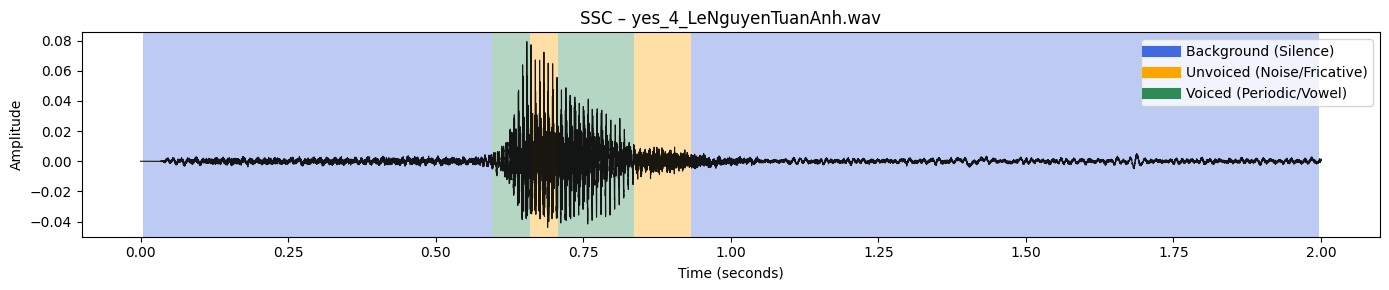

Sequence: { -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 }
Counts: {np.int64(-1): np.int64(207), np.int64(0): np.int64(18), np.int64(1): np.int64(24)}

=== HDGC on yes_4_LeNguyenTuanAnh.wav (LeNguyenTuanAnh) ===


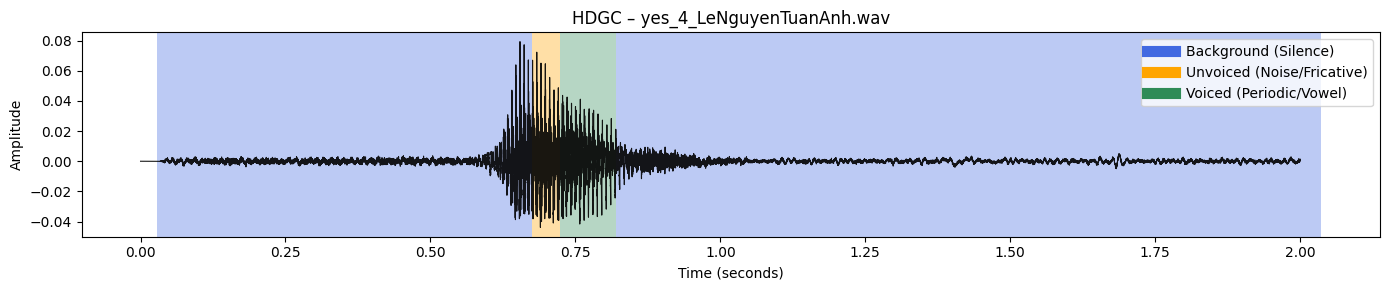

Sequence: { -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 }
Counts: {np.int64(-1): np.int64(233), np.int64(0): np.int64(6), np.int64(1): np.int64(12)}


In [23]:
example_path, example_spk = train_files[34]
y, _ = librosa.load(example_path, sr=SR)

for name, func in [("HHTC", hhtc_classify),
                   ("SSC", ssc_classify),
                   ("HDGC", hdgc_classify)]:
    labels, times = func(y)
    print(f"\n=== {name} on {os.path.basename(example_path)} ({example_spk}) ===")
    plot_classification(y, SR, labels, times, title=f"{name} – {os.path.basename(example_path)}")


## Sequence-Level Features

`sequence_to_features` converts a label sequence into 13 structural features: counts/ratios, longest voiced run, transitions, and selected bigram counts.

In [24]:
def sequence_to_features(seq):
    seq = np.asarray(seq, dtype=int)
    L = len(seq)

    # basic counts
    c_bg = np.sum(seq == LABEL_BACKGROUND)
    c_uv = np.sum(seq == LABEL_UNVOICED)
    c_v  = np.sum(seq == LABEL_VOICED)

    # ratios
    r_v  = c_v  / max(L, 1)
    r_uv = c_uv / max(L, 1)
    r_bg = c_bg / max(L, 1)

    # longest contiguous run of voiced
    longest_v = 0
    current = 0
    for x in seq:
        if x == LABEL_VOICED:
            current += 1
            longest_v = max(longest_v, current)
        else:
            current = 0

    # transitions
    transitions = np.sum(seq[1:] != seq[:-1]) if L > 1 else 0

    # simple n-gram like: count of BG→V, BG→UV, UV→V, V→UV
    def count_pair(a, b):
        return np.sum((seq[:-1] == a) & (seq[1:] == b)) if L > 1 else 0

    bg_to_v  = count_pair(LABEL_BACKGROUND, LABEL_VOICED)
    bg_to_uv = count_pair(LABEL_BACKGROUND, LABEL_UNVOICED)
    uv_to_v  = count_pair(LABEL_UNVOICED,   LABEL_VOICED)
    v_to_uv  = count_pair(LABEL_VOICED,     LABEL_UNVOICED)

    feats = np.array([
        L,
        c_bg, c_uv, c_v,
        r_bg, r_uv, r_v,
        longest_v,
        transitions,
        bg_to_v, bg_to_uv, uv_to_v, v_to_uv,
    ], dtype=float)

    return feats


## File-Level Features for Speaker ID

`file_to_features_with_mfcc` builds a 53-D vector per file per algorithm:
- 13 sequence features from that algorithm’s labels.
- 40 MFCC stats (20 means, 20 stds) computed on voiced frames (fallback to speech, then all frames).
These features feed the speaker recognition SVM.

In [25]:
def file_to_features_with_mfcc(path, algo_func, n_mfcc=20):
    """Build 53-D feature: 13 sequence stats + MFCC means/stds on voiced frames (fallback to speech/all)."""
    y, _ = librosa.load(path, sr=SR)

    seq, _ = algo_func(y)
    seq = np.asarray(seq, dtype=int)

    basic_feats = sequence_to_features(seq)

    mfcc = librosa.feature.mfcc(
        y=y,
        sr=SR,
        n_mfcc=n_mfcc,
        n_fft=512,
        hop_length=HOP_LEN,
        win_length=FRAME_LEN,
        window="hann",
    )

    T = mfcc.shape[1]
    L = len(seq)
    n = min(T, L)
    if n == 0:
        return np.concatenate([basic_feats, np.zeros(2 * n_mfcc, dtype=float)])

    mfcc = mfcc[:, :n]
    seq = seq[:n]

    voiced_idx = (seq == LABEL_VOICED)
    speech_idx = (seq != LABEL_BACKGROUND)

    # prefer MFCC stats on voiced frames; fallback to speech-only, then all frames
    if np.any(voiced_idx):
        mfcc_sel = mfcc[:, voiced_idx]
    elif np.any(speech_idx):
        mfcc_sel = mfcc[:, speech_idx]
    else:
        mfcc_sel = mfcc

    mfcc_mean = np.mean(mfcc_sel, axis=1)
    mfcc_std  = np.std(mfcc_sel,  axis=1)
    mfcc_stats = np.concatenate([mfcc_mean, mfcc_std])

    feats = np.concatenate([basic_feats, mfcc_stats])
    return feats

In [26]:
def compute_sequences_for_files(file_list):
    all_data = {}  # maps (path, spk) -> {algo_name: seq}
    for path, spk in file_list:
        y, _ = librosa.load(path, sr=SR)
        per_algo = {}
        for algo_name, algo_func in ALGORITHMS:
            per_algo[algo_name], _ = algo_func(y)
        all_data[(path, spk)] = per_algo
    return all_data

train_sequences = compute_sequences_for_files(train_files)
test_sequences  = compute_sequences_for_files(test_files)

In [27]:
def build_Xy_mfcc(file_list, algo_func, n_mfcc=20):
    """
    Build X, y, paths for a given algorithm function (hhtc_classify / ssc_classify / hdgc_classify)
    using richer features (sequence stats + MFCC stats on voiced frames).
    """
    X, y, paths = [], [], []
    for path, spk in file_list:
        feats = file_to_features_with_mfcc(path, algo_func, n_mfcc=n_mfcc)
        X.append(feats)
        y.append(spk)
        paths.append(path)
    return np.vstack(X), np.array(y), paths


## Training & Comparison via Speaker Recognition (Proxy)

We lack frame-level V/UV/B ground truth, so we compare algorithms indirectly:
- For each algorithm (HHTC, SSC, HDGC):
  1) Build train/test features (sequence + MFCC stats on voiced frames).
  2) Train SVM (RBF, `C=10`, `gamma=scale`) with standardization.
  3) Report accuracy, precision/recall/F1, confusion matrix.
- Higher speaker-ID accuracy ⇒ cleaner V/UV/B segmentation for this dataset.

In [28]:
# Algorithm registry used for speaker-ID comparison
results_speaker = {}

for name, func in ALGORITHMS:
    print("\n" + "="*80)
    print(f"Speaker recognition using {name} (sequence stats + MFCC on voiced)")

    X_tr, y_tr, paths_tr = build_Xy_mfcc(train_files, func, n_mfcc=20)
    X_te, y_te, paths_te = build_Xy_mfcc(test_files,  func, n_mfcc=20)

    print("Train shape:", X_tr.shape, "Test shape:", X_te.shape)

    clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", C=10.0, gamma="scale", probability=False)
    )
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    print(f"Accuracy ({name}): {acc*100:.2f}%")
    print("\nClassification report:")
    print(classification_report(y_te, y_pred))

    print("Confusion matrix (rows = true, cols = predicted):")
    print(confusion_matrix(y_te, y_pred, labels=np.unique(y_te)))

    results_speaker[name] = {
        "model": clf,
        "accuracy": acc,
        "y_true": y_te,
        "y_pred": y_pred,
        "paths_test": paths_te,
    }


Speaker recognition using HHTC (sequence stats + MFCC on voiced)
Train shape: (120, 53) Test shape: (120, 53)
Accuracy (HHTC): 100.00%

Classification report:
                 precision    recall  f1-score   support

LeNguyenTuanAnh       1.00      1.00      1.00        40
  LuongBinhMinh       1.00      1.00      1.00        40
  TranQuangThai       1.00      1.00      1.00        40

       accuracy                           1.00       120
      macro avg       1.00      1.00      1.00       120
   weighted avg       1.00      1.00      1.00       120

Confusion matrix (rows = true, cols = predicted):
[[40  0  0]
 [ 0 40  0]
 [ 0  0 40]]

Speaker recognition using SSC (sequence stats + MFCC on voiced)
Train shape: (120, 53) Test shape: (120, 53)
Accuracy (SSC): 100.00%

Classification report:
                 precision    recall  f1-score   support

LeNguyenTuanAnh       1.00      1.00      1.00        40
  LuongBinhMinh       1.00      1.00      1.00        40
  TranQuangThai      

## Inspecting a Test Example

`inspect_one_test_example(index=...)` reruns all three algorithms on one file, shows the predicted speaker from each SVM, and plots the V/UV/B labels for visual comparison.

File: d:\ImportantProjects\SpeechProcessing\Project\test\LeNguyenTuanAnh\yes_4_LeNguyenTuanAnh.wav
True speaker: LeNguyenTuanAnh

Algorithm: HHTC
Predicted speaker: LeNguyenTuanAnh


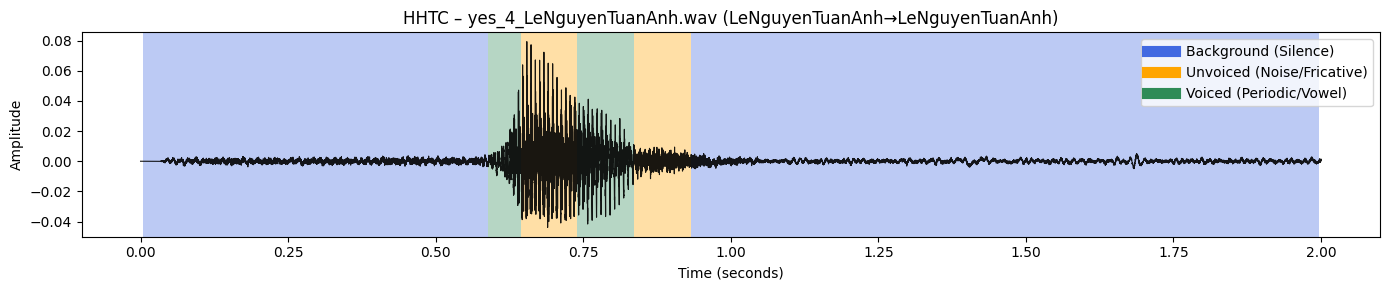

Sequence: { -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 }
Counts: {np.int64(-1): np.int64(206), np.int64(0): np.int64(24), np.int64(1): np.int64(19)}

Algorithm: SSC
Predicted speaker: LeNguyenTuanAnh


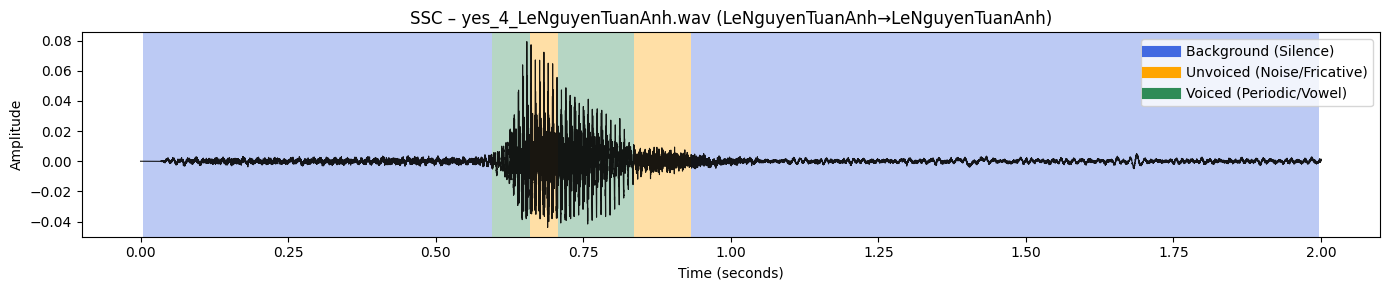

Sequence: { -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 }
Counts: {np.int64(-1): np.int64(207), np.int64(0): np.int64(18), np.int64(1): np.int64(24)}

Algorithm: HDGC
Predicted speaker: LeNguyenTuanAnh


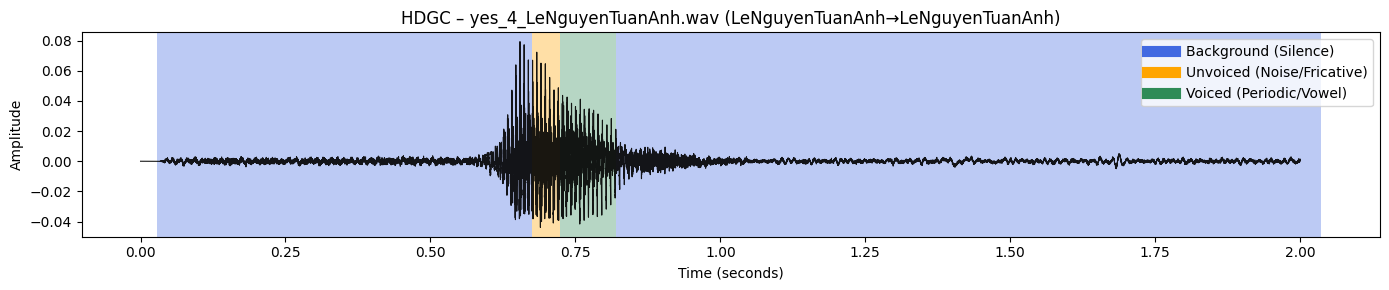

Sequence: { -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 }
Counts: {np.int64(-1): np.int64(233), np.int64(0): np.int64(6), np.int64(1): np.int64(12)}


In [29]:
def inspect_one_test_example(index=0):
    # we'll always use HHTC list to pick the test file & true label
    path = results_speaker["HHTC"]["paths_test"][index]
    true_spk = results_speaker["HHTC"]["y_true"][index]
    print("File:", path)
    print("True speaker:", true_spk)

    y, _ = librosa.load(path, sr=SR)

    for name, func in [("HHTC", hhtc_classify),
                       ("SSC",  ssc_classify),
                       ("HDGC", hdgc_classify)]:
        # run algorithm to get sequence, also for plotting
        seq, times = func(y)

        # build the same feature vector type used in training
        feats = file_to_features_with_mfcc(path, func, n_mfcc=20)

        pred_spk = results_speaker[name]["model"].predict(
            feats.reshape(1, -1)
        )[0]

        print(f"\nAlgorithm: {name}")
        print("Predicted speaker:", pred_spk)

        plot_classification(
            y, SR, seq, times,
            title=f"{name} – {os.path.basename(path)} ({true_spk}→{pred_spk})"
        )

# example
inspect_one_test_example(34)
